In [1]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms


In [2]:
# Params
device = torch.device('cuda')

# Image and noise input
image_size = 28
n_chans = 1

# nn & opt
nf = 32
batch_size = 512
num_epochs = 150
n_emb = 10
emb_sz = 30

data = datasets.MNIST('.', train=True, download=True,
                      transform=transforms.ToTensor())

dl = torch.utils.data.DataLoader(data, batch_size = batch_size)

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def t_conv_block(in_c, out_c, ks, s, pad, bias = False):
    # Transposed conv a.k.a. upsampling
    return nn.Sequential(nn.ConvTranspose2d(in_c , out_c, ks, s, 
                                            pad, bias = bias),
                         nn.BatchNorm2d(out_c),
                         nn.LeakyReLU(inplace = True, 
                                      negative_slope = 0.1))

def conv_block(in_c, out_c, ks, s, pad, bias = False):
    return nn.Sequential(nn.Conv2d(in_c, out_c, ks, s, 
                                   pad, bias = bias),
                         nn.BatchNorm2d(out_c),
                         nn.LeakyReLU(inplace = True, 
                                      negative_slope = 0.1))

class ResBlock(nn.Module):
    def __init__(self, in_c, out_c, ks, s, pad, bias = False):
        super().__init__()
        self.conv1 = conv_block(in_c, out_c, ks, s, pad, bias = False)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1, bias = False)
        self.act = nn.LeakyReLU(inplace = True,negative_slope = 0.1)
        
    def forward(self, x):
        res = self.conv1(x)
        x = self.conv2(res)
        return self.act(x + res)
    
class TResBlock(nn.Module):
    def __init__(self, in_c, out_c, ks, s, pad, bias = False):
        super().__init__()
        self.conv1 = t_conv_block(in_c, out_c, ks, s, pad, bias = False)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1, bias = False)
        self.act = nn.LeakyReLU(inplace = True,negative_slope = 0.1)
        
    def forward(self, x):
        res = self.conv1(x)
        x = self.conv2(res)
        return self.act(x + res)
        

class Discriminator(nn.Module):
    # Acts as gan discriminator, i.e. binary classifier that 
    # predicts {Generated Image, True Image} given images.
    # Also has a 10-class classifier that learns to recognize digits
    # in addition to {Generated Image, Legitimage Image}, can't hurt,
    # probably helps. 
    def __init__(self, nf = 16):
        super().__init__()
        layers = [ResBlock(n_chans, nf, 4, 2, 1), # (1, 28, 28) -> (nf, 14, 14)
                  nn.Dropout2d(0.1),
                  ResBlock(nf, nf * 2, 4, 2, 1), # (nf, 14, 14) -> (nf *2, 7, 7)
                  nn.Dropout2d(0.1),
                  ResBlock(nf * 2, nf * 4, 4, 2, 1), # (nf *4, 7, 7)
                  nn.Dropout2d(0.1),
                  nn.Conv2d(nf * 4, nf * 4, 3, 1, 1),
                  nn.AdaptiveAvgPool2d(1),
                  nn.Flatten(),
                  ]
        # Conv base
        self.conv_layers = nn.Sequential(*layers)
        # Binary classifier {generated, true}
        self.disc = nn.Sequential(nn.Linear(nf * 4, 1, bias = True), 
                                   nn.Sigmoid())
        # Digit recognizer
        self.clas = nn.Linear(nf * 4, 10, bias = True)
        self.apply(weights_init)

    def forward(self, x):
        x = self.conv_layers(x)
        return self.disc(x), F.log_softmax(self.clas(x), dim = -1)
    
class Generator(nn.Module):
    # Generates (1, 28, 28) images from noise vectors of size (emb_sz, 1, 1)
    # with the help of 3 deconvolution blocks and 2 conv blocks.
    #
    # Deconvolution blocks upsample the image from (emb_sz, 1, 1) to (nf, 7, 7) 
    # to (nf * 2, 14, 14) to (nf * 4, 28, 28).
    #
    # Conv blocks only play with the image's depth and are not strictly necessary.
    #
    # Contrary to vanilla GANs, the image is not generated purely from a noise vector as input.
    # Instead, inputs are learnt embeddings, to which gaussian noise is added.
    # Hopefully these embeddings can help generating digits of our choice.
    # A small digit classifier is added right after the embedding layer to enforce this effect.
    def __init__(self, nf = 16, emb_sz = emb_sz):
        super().__init__()
        self.emb = Embeddor()
        self.cls = nn.Linear(emb_sz, 10)
        layers = [TResBlock(emb_sz, nf, 7, 1, 0),
                  TResBlock(nf, nf * 2, 4, 2, 1),
                  TResBlock(nf * 2, nf * 4, 4, 2, 1),
                  ResBlock(nf * 4, nf * 8, 3, 1, 1),
                  nn.Conv2d(nf * 8, 1, kernel_size = 3, 
                            stride = 1, padding = 1, bias = False),
                  nn.Sigmoid()]
        self.layers = nn.Sequential(*layers)
        self.apply(weights_init)
        
    def forward(self, x):
        emb = self.emb(x)
        return self.layers(emb[...,None,None]), F.log_softmax(self.cls(emb), dim = -1)
    
class Embeddor(nn.Module):
    def __init__(self, n_emb = 10, emb_sz = emb_sz):
        super().__init__()
        self.emb_sz = emb_sz
        self.emb = nn.Embedding(n_emb, emb_sz)
    
    def forward(self, x):
        return (self.emb(x) 
                + 0.5 * torch.randn(batch_size, self.emb_sz, device=device))

In [4]:
g = Generator().to(device)
d = Discriminator().to(device)

loss_func = nn.BCELoss()

g_opt = optim.Adam(g.parameters(), lr = 1e-4)
g_sched = torch.optim.lr_scheduler.OneCycleLR(g_opt, max_lr = 1e-4, 
                                              epochs = num_epochs, 
                                              steps_per_epoch = len(dl) - 1)

d_opt = optim.Adam(d.parameters(), lr = 1e-4)
d_sched = torch.optim.lr_scheduler.OneCycleLR(d_opt, max_lr = 1e-4, 
                                              epochs = num_epochs, 
                                              steps_per_epoch = len(dl) - 1)

In [5]:
def discriminator_step(x, y):
    d_opt.zero_grad()
    
    # train discriminator on real data
    d_out, y_out = d(x)
    # binary GAN loss: true data, 1's as output
    loss_real = loss_func(d_out, torch.ones(batch_size, 1).to(device))
    # custom digit classifier loss
    loss_real += 0.1 * F.nll_loss(y_out, y)
    
    # train discriminator on generated data
    z = torch.randint(low = 0, high = n_emb, size = (batch_size,)).to(device)
    g_out, _ = g(z)
    d_out, y_out = d(g_out)
    # binary GAN loss: fake data, 0's as output
    loss_gen = loss_func(d_out, torch.zeros(batch_size, 1).to(device))

    loss = loss_real + loss_gen
    loss.backward()
    d_opt.step()
    d_sched.step()
    return loss.data.item()

def generator_step(x):
    g_opt.zero_grad()
    
    # generating random ints to be embedded
    z = torch.randint(low = 0, high = n_emb, size = (batch_size,)).to(device)
    
    g_out, embeddings = g(z)
    d_out, y_out  = d(g_out)
    # binary GAN loss: fake data but 1's as output as we train the generator
    # to fool the discriminator
    loss = loss_func(d_out, torch.ones(batch_size, 1).to(device))
    # custom digit classifier loss, directly from embeddings and from the
    # discriminator's output (not sure it's a good idea)
    loss += 0.1 * F.nll_loss(y_out, z) + 0.025 * F.nll_loss(embeddings, z)
    
    loss.backward()
    g_opt.step()
    g_sched.step()
    return loss.data.item()

def train_step(x, y):
    return discriminator_step(x, y), generator_step(x)

In [6]:
def plot_generated():
    # plotting generator's output when given [0, ..., 9]
    # as input embeddings
    with torch.no_grad():
        for i in range(n_emb):
            gen, _ = g(torch.tensor([i]).to(device))
            plt.figure(figsize = (1,1))
            plt.imshow(((gen[i].squeeze(0).cpu().numpy())), cmap='gray')
            plt.show()


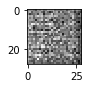

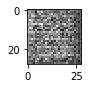

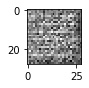

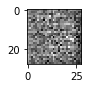

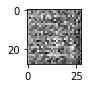

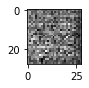

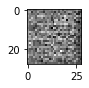

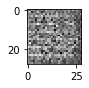

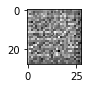

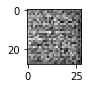

Epoch 1: gen loss 0.98 
disc loss 1.62


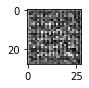

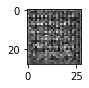

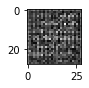

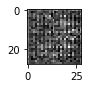

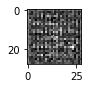

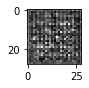

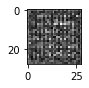

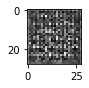

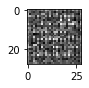

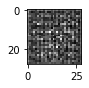

Epoch 2: gen loss 0.98 
disc loss 1.59


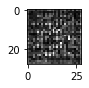

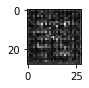

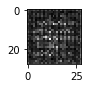

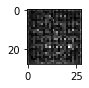

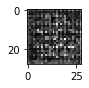

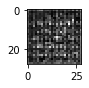

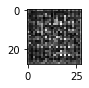

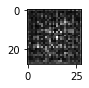

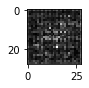

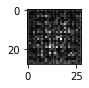

Epoch 3: gen loss 0.98 
disc loss 1.58


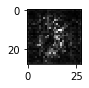

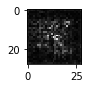

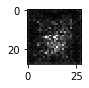

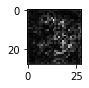

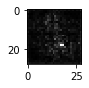

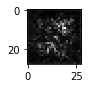

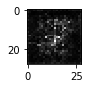

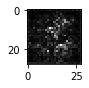

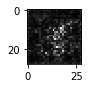

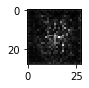

Epoch 4: gen loss 0.97 
disc loss 1.59


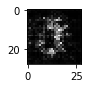

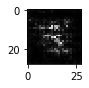

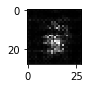

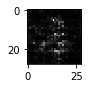

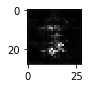

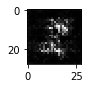

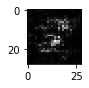

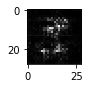

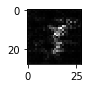

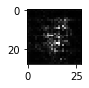

Epoch 5: gen loss 0.97 
disc loss 1.6


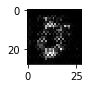

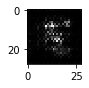

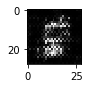

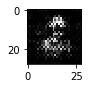

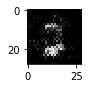

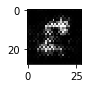

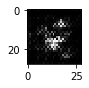

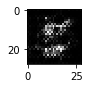

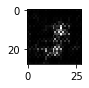

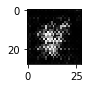

Epoch 6: gen loss 0.97 
disc loss 1.61


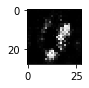

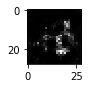

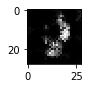

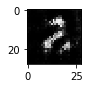

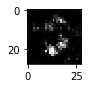

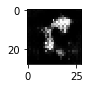

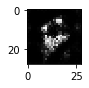

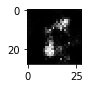

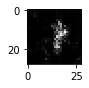

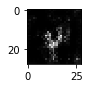

Epoch 7: gen loss 0.98 
disc loss 1.6


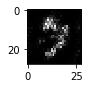

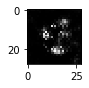

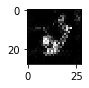

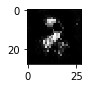

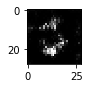

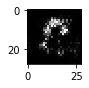

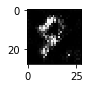

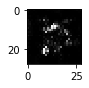

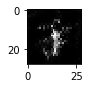

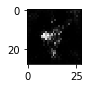

Epoch 8: gen loss 0.98 
disc loss 1.61


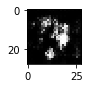

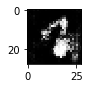

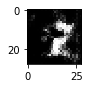

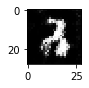

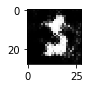

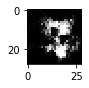

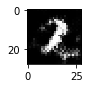

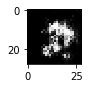

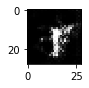

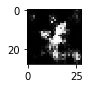

Epoch 9: gen loss 0.98 
disc loss 1.61


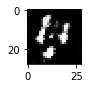

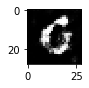

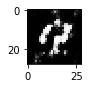

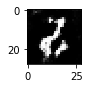

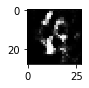

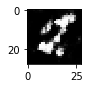

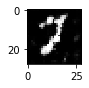

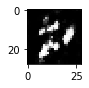

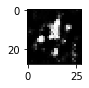

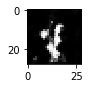

Epoch 10: gen loss 0.99 
disc loss 1.59


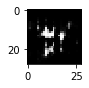

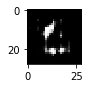

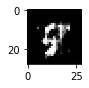

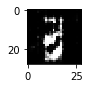

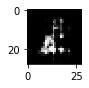

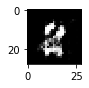

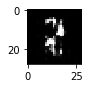

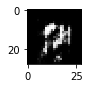

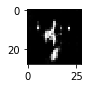

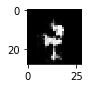

Epoch 11: gen loss 0.98 
disc loss 1.6


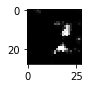

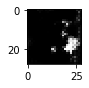

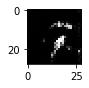

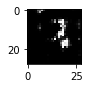

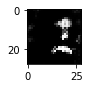

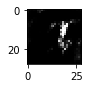

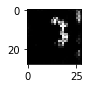

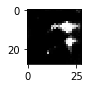

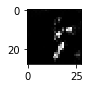

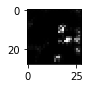

Epoch 12: gen loss 1.0 
disc loss 1.58


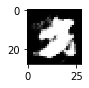

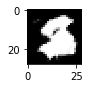

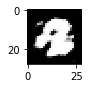

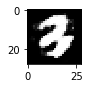

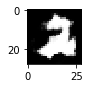

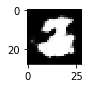

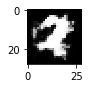

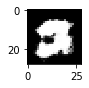

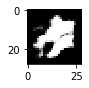

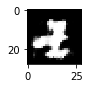

Epoch 13: gen loss 1.0 
disc loss 1.52


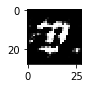

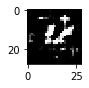

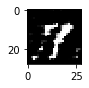

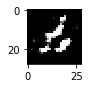

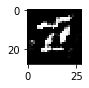

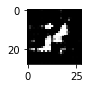

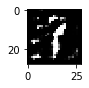

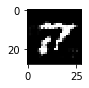

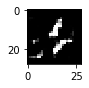

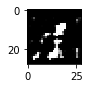

Epoch 14: gen loss 1.07 
disc loss 1.5


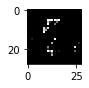

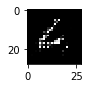

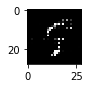

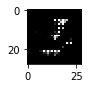

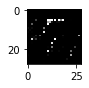

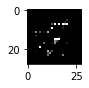

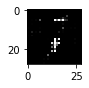

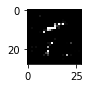

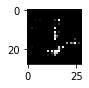

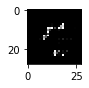

Epoch 15: gen loss 1.05 
disc loss 1.55


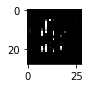

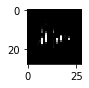

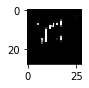

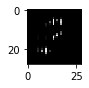

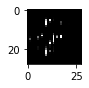

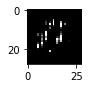

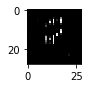

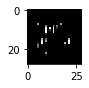

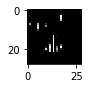

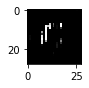

Epoch 16: gen loss 1.07 
disc loss 1.54


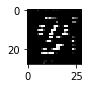

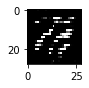

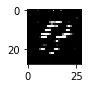

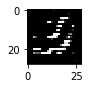

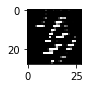

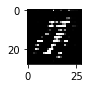

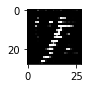

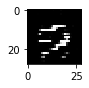

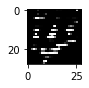

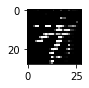

Epoch 17: gen loss 1.78 
disc loss 0.98


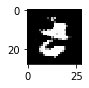

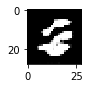

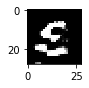

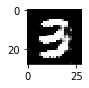

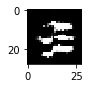

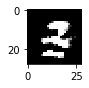

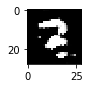

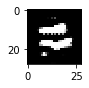

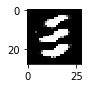

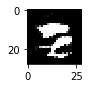

Epoch 18: gen loss 1.42 
disc loss 1.33


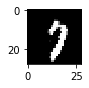

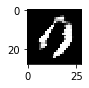

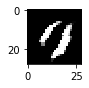

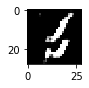

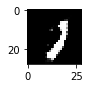

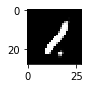

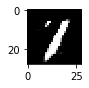

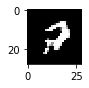

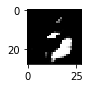

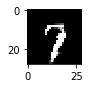

Epoch 19: gen loss 1.48 
disc loss 1.26


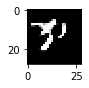

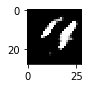

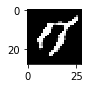

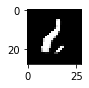

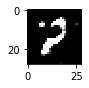

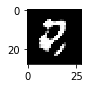

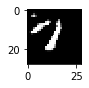

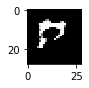

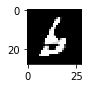

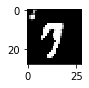

Epoch 20: gen loss 1.57 
disc loss 1.23


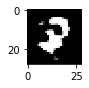

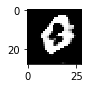

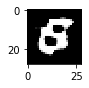

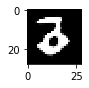

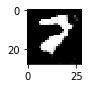

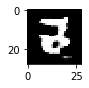

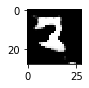

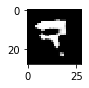

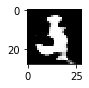

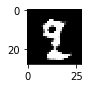

Epoch 21: gen loss 1.39 
disc loss 1.34


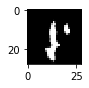

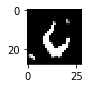

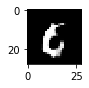

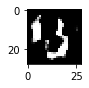

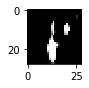

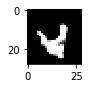

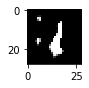

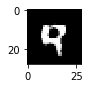

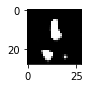

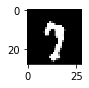

Epoch 22: gen loss 1.51 
disc loss 1.19


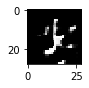

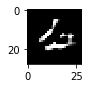

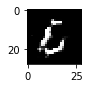

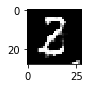

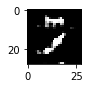

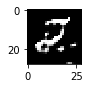

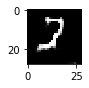

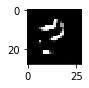

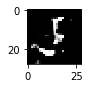

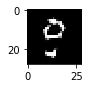

Epoch 23: gen loss 1.26 
disc loss 1.42


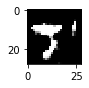

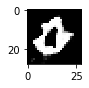

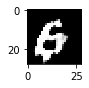

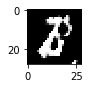

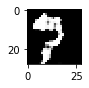

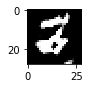

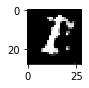

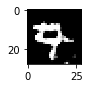

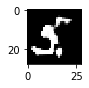

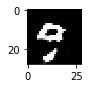

Epoch 24: gen loss 1.39 
disc loss 1.27


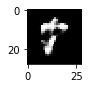

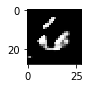

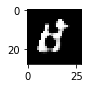

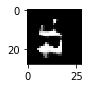

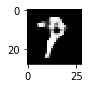

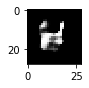

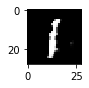

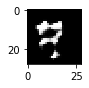

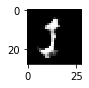

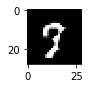

Epoch 25: gen loss 1.37 
disc loss 1.31


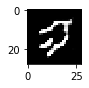

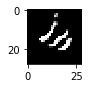

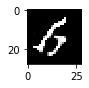

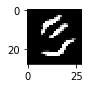

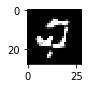

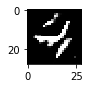

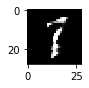

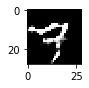

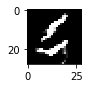

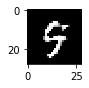

Epoch 26: gen loss 1.43 
disc loss 1.25


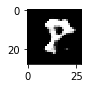

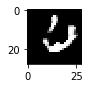

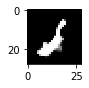

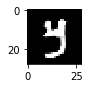

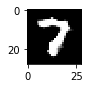

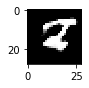

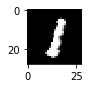

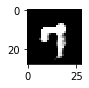

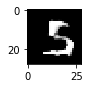

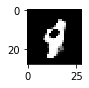

Epoch 27: gen loss 1.41 
disc loss 1.24


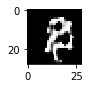

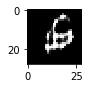

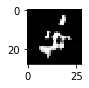

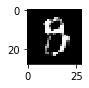

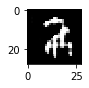

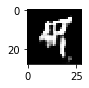

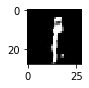

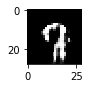

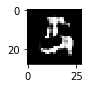

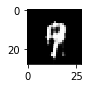

Epoch 28: gen loss 1.46 
disc loss 1.23


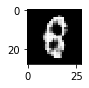

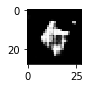

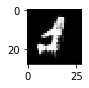

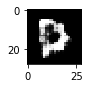

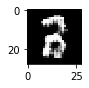

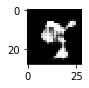

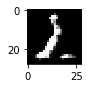

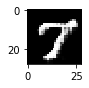

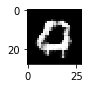

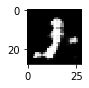

Epoch 29: gen loss 1.5 
disc loss 1.23


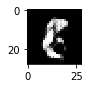

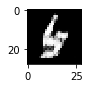

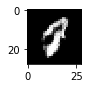

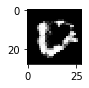

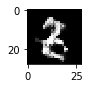

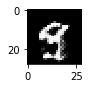

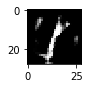

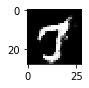

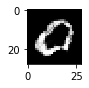

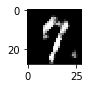

Epoch 30: gen loss 1.47 
disc loss 1.22


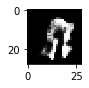

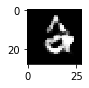

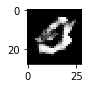

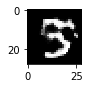

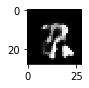

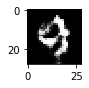

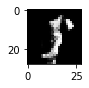

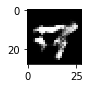

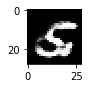

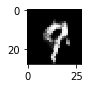

Epoch 31: gen loss 1.27 
disc loss 1.33


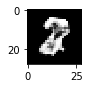

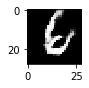

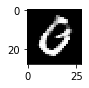

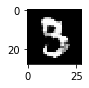

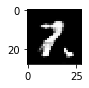

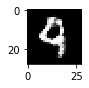

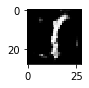

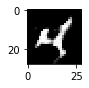

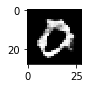

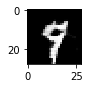

Epoch 32: gen loss 1.36 
disc loss 1.22


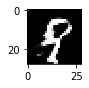

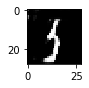

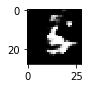

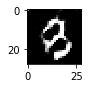

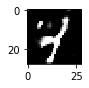

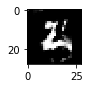

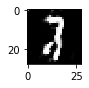

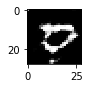

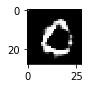

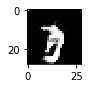

Epoch 33: gen loss 1.4 
disc loss 1.17


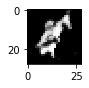

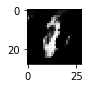

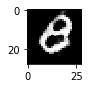

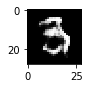

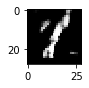

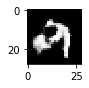

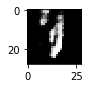

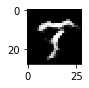

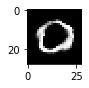

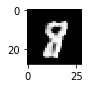

Epoch 34: gen loss 1.42 
disc loss 1.26


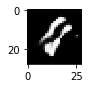

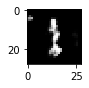

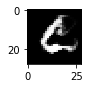

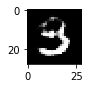

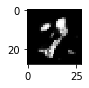

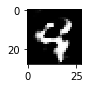

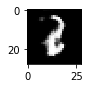

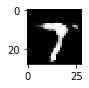

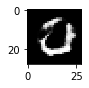

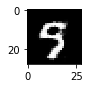

Epoch 35: gen loss 1.28 
disc loss 1.26


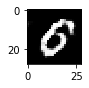

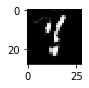

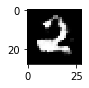

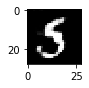

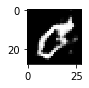

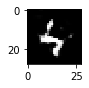

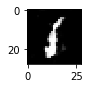

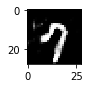

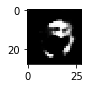

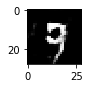

Epoch 36: gen loss 1.29 
disc loss 1.22


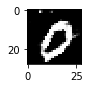

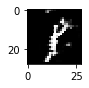

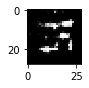

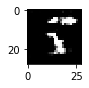

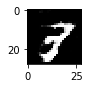

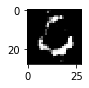

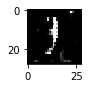

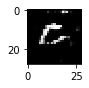

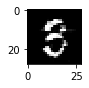

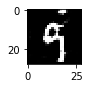

Epoch 37: gen loss 1.41 
disc loss 1.13


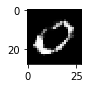

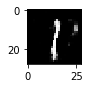

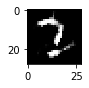

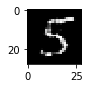

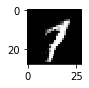

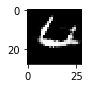

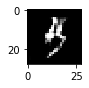

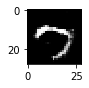

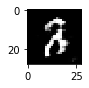

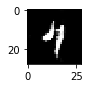

Epoch 38: gen loss 1.31 
disc loss 1.24


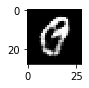

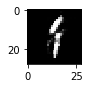

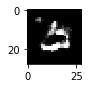

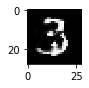

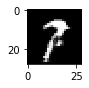

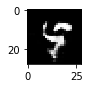

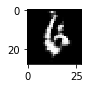

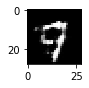

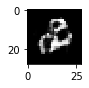

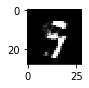

Epoch 39: gen loss 1.3 
disc loss 1.2


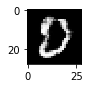

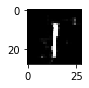

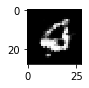

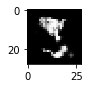

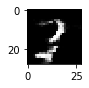

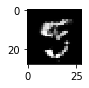

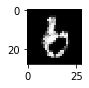

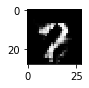

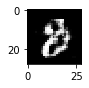

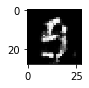

Epoch 40: gen loss 1.23 
disc loss 1.25


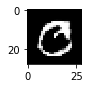

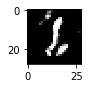

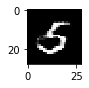

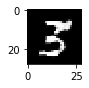

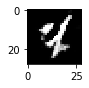

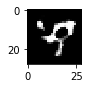

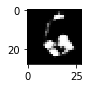

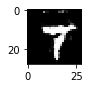

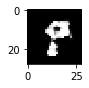

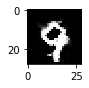

Epoch 41: gen loss 1.35 
disc loss 1.13


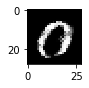

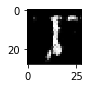

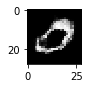

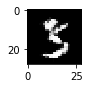

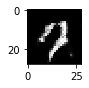

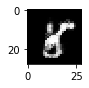

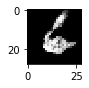

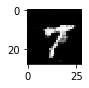

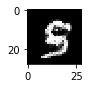

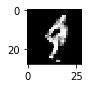

Epoch 42: gen loss 1.39 
disc loss 1.16


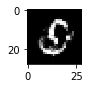

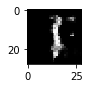

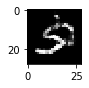

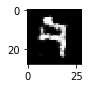

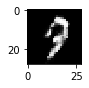

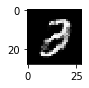

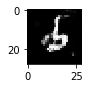

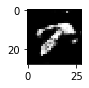

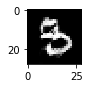

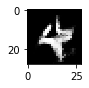

Epoch 43: gen loss 1.31 
disc loss 1.19


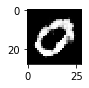

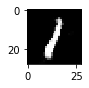

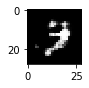

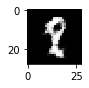

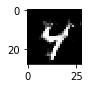

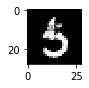

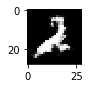

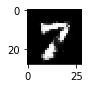

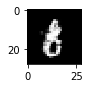

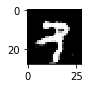

Epoch 44: gen loss 1.28 
disc loss 1.19


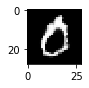

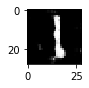

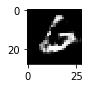

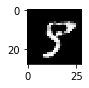

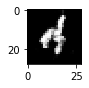

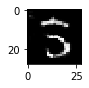

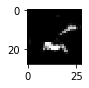

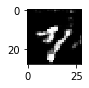

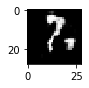

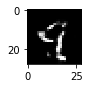

Epoch 45: gen loss 1.2 
disc loss 1.27


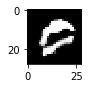

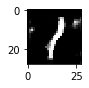

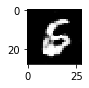

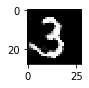

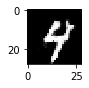

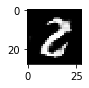

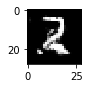

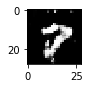

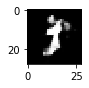

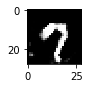

Epoch 46: gen loss 1.2 
disc loss 1.29


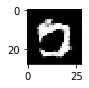

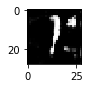

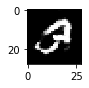

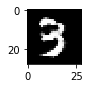

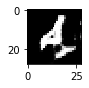

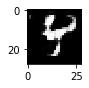

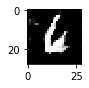

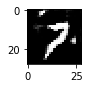

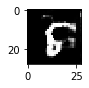

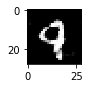

Epoch 47: gen loss 1.28 
disc loss 1.15


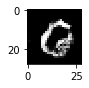

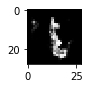

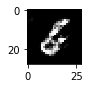

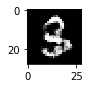

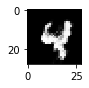

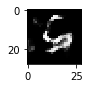

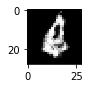

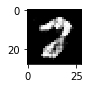

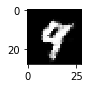

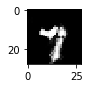

Epoch 48: gen loss 1.43 
disc loss 1.09


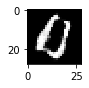

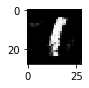

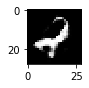

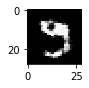

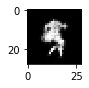

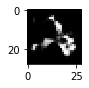

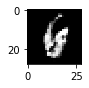

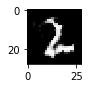

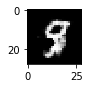

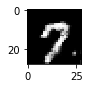

Epoch 49: gen loss 1.38 
disc loss 1.12


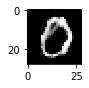

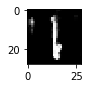

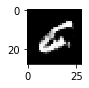

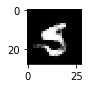

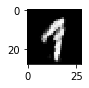

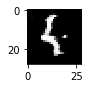

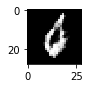

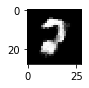

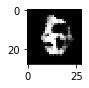

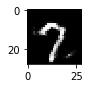

Epoch 50: gen loss 1.49 
disc loss 1.12


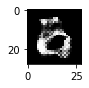

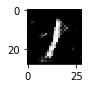

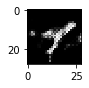

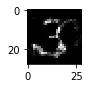

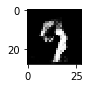

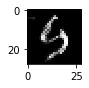

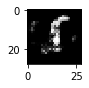

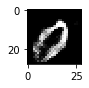

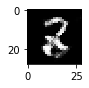

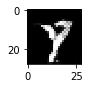

Epoch 51: gen loss 1.35 
disc loss 1.2


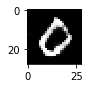

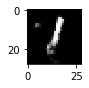

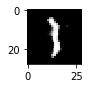

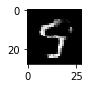

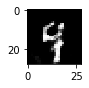

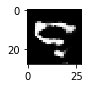

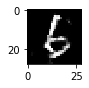

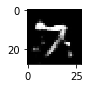

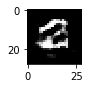

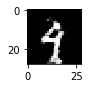

Epoch 52: gen loss 1.41 
disc loss 1.13


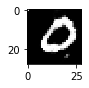

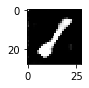

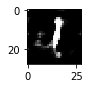

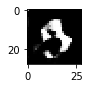

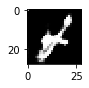

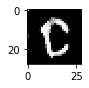

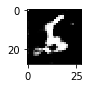

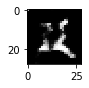

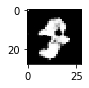

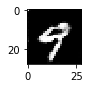

Epoch 53: gen loss 1.37 
disc loss 1.09


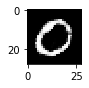

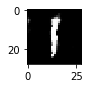

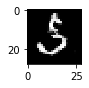

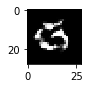

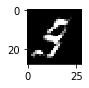

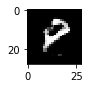

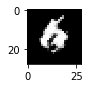

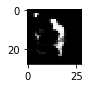

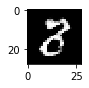

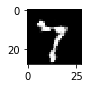

Epoch 54: gen loss 1.56 
disc loss 1.07


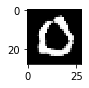

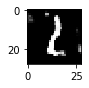

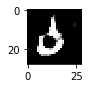

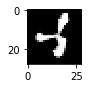

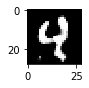

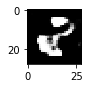

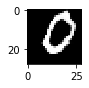

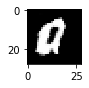

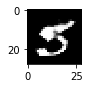

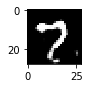

Epoch 55: gen loss 1.67 
disc loss 1.04


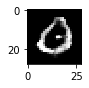

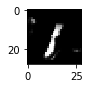

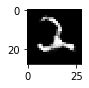

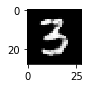

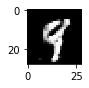

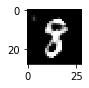

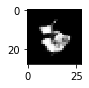

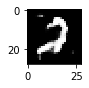

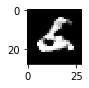

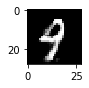

Epoch 56: gen loss 1.43 
disc loss 1.14


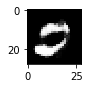

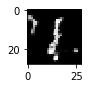

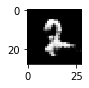

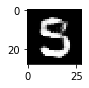

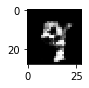

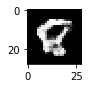

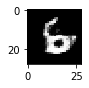

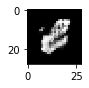

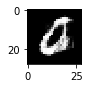

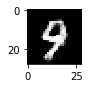

Epoch 57: gen loss 1.52 
disc loss 1.05


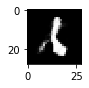

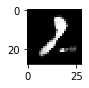

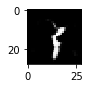

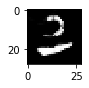

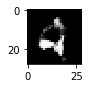

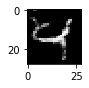

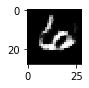

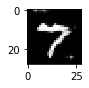

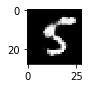

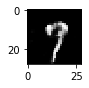

Epoch 58: gen loss 1.48 
disc loss 1.11


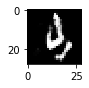

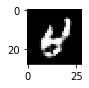

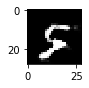

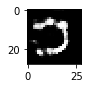

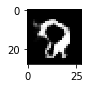

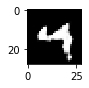

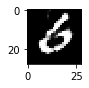

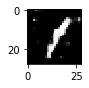

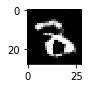

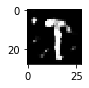

Epoch 59: gen loss 1.78 
disc loss 1.01


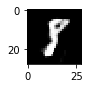

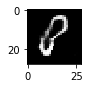

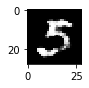

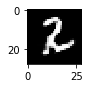

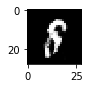

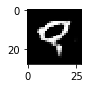

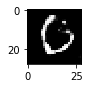

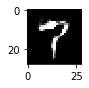

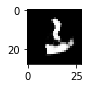

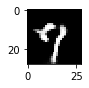

Epoch 60: gen loss 1.76 
disc loss 1.16


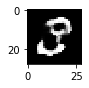

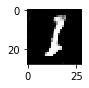

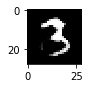

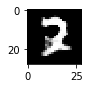

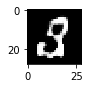

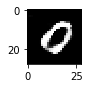

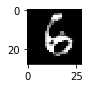

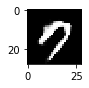

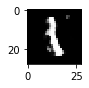

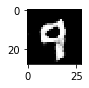

Epoch 61: gen loss 1.67 
disc loss 1.06


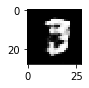

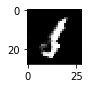

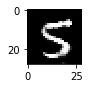

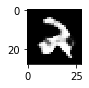

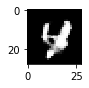

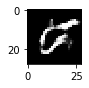

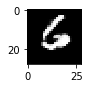

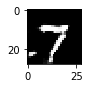

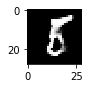

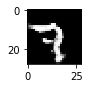

Epoch 62: gen loss 1.51 
disc loss 1.1


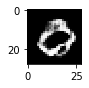

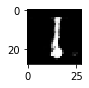

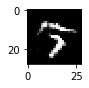

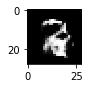

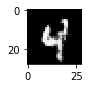

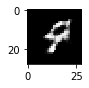

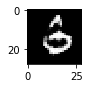

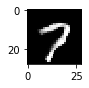

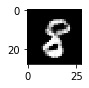

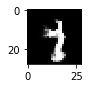

Epoch 63: gen loss 1.53 
disc loss 1.1


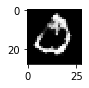

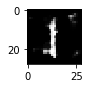

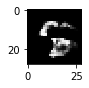

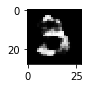

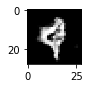

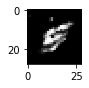

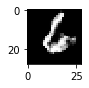

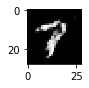

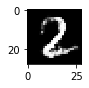

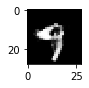

Epoch 64: gen loss 1.28 
disc loss 1.2


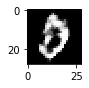

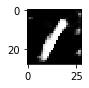

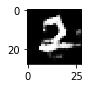

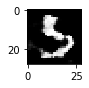

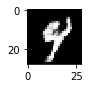

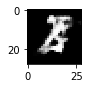

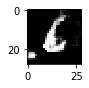

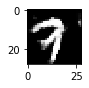

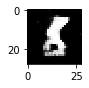

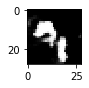

Epoch 65: gen loss 1.22 
disc loss 1.18


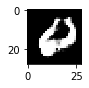

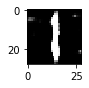

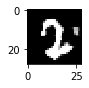

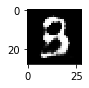

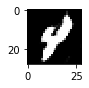

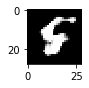

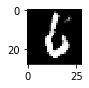

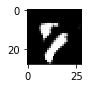

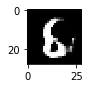

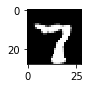

Epoch 66: gen loss 1.35 
disc loss 1.12


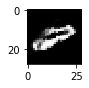

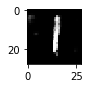

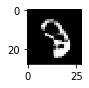

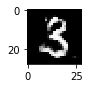

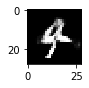

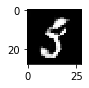

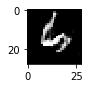

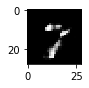

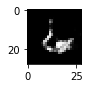

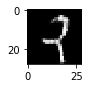

Epoch 67: gen loss 1.7 
disc loss 0.86


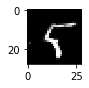

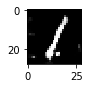

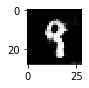

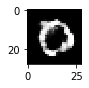

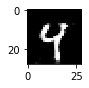

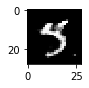

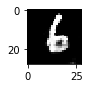

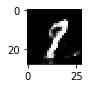

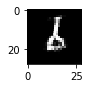

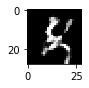

Epoch 68: gen loss 1.59 
disc loss 1.14


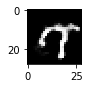

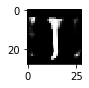

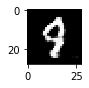

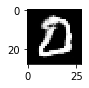

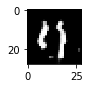

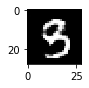

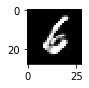

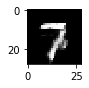

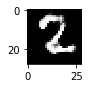

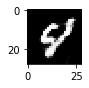

Epoch 69: gen loss 1.53 
disc loss 1.19


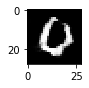

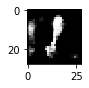

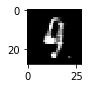

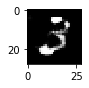

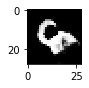

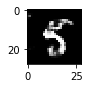

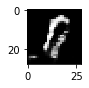

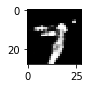

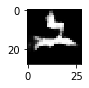

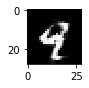

Epoch 70: gen loss 1.45 
disc loss 1.13


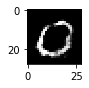

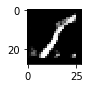

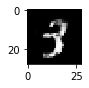

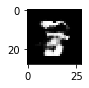

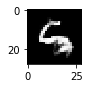

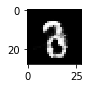

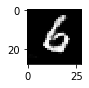

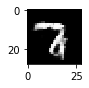

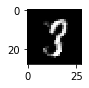

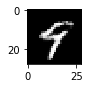

Epoch 71: gen loss 1.4 
disc loss 1.06


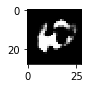

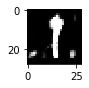

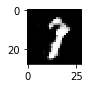

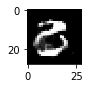

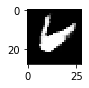

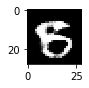

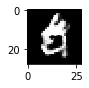

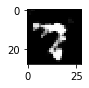

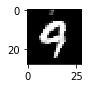

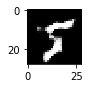

Epoch 72: gen loss 1.44 
disc loss 1.12


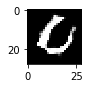

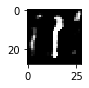

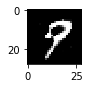

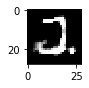

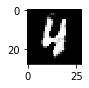

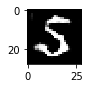

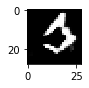

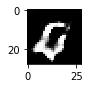

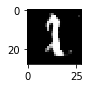

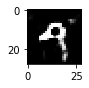

Epoch 73: gen loss 1.6 
disc loss 0.97


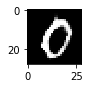

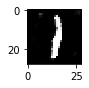

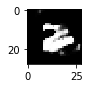

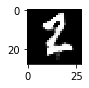

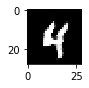

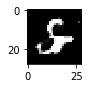

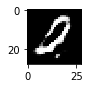

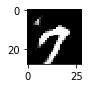

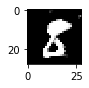

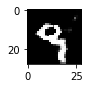

Epoch 74: gen loss 1.78 
disc loss 0.89


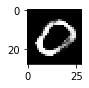

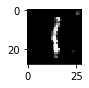

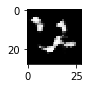

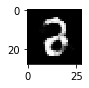

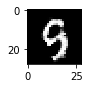

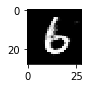

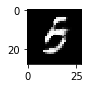

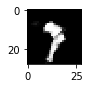

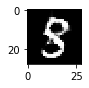

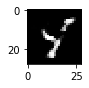

Epoch 75: gen loss 1.73 
disc loss 1.01


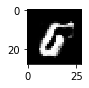

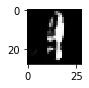

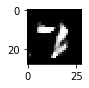

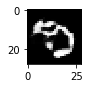

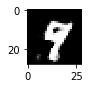

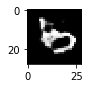

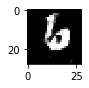

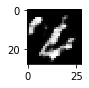

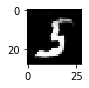

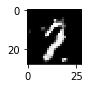

Epoch 76: gen loss 1.63 
disc loss 1.07


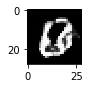

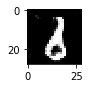

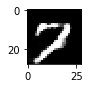

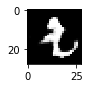

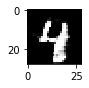

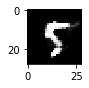

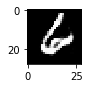

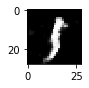

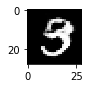

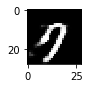

Epoch 77: gen loss 1.6 
disc loss 1.09


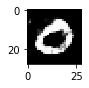

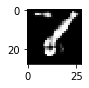

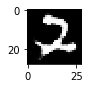

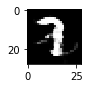

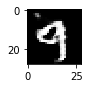

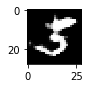

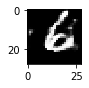

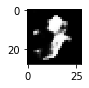

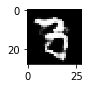

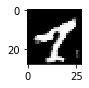

Epoch 78: gen loss 1.47 
disc loss 1.06


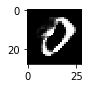

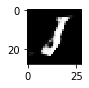

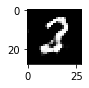

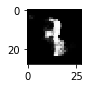

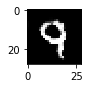

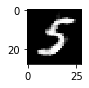

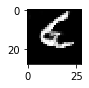

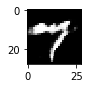

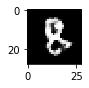

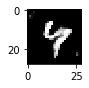

Epoch 79: gen loss 1.41 
disc loss 1.06


KeyboardInterrupt: 

In [7]:
for ep in range(1, num_epochs + 1):

    d_losses = []
    g_losses = []
    for x, y in tqdm(dl):
        if x.size(0) == batch_size:
            d_loss, g_loss = train_step(x.to(device), y.to(device))
            d_losses.append(d_loss)
            g_losses.append(g_loss)
            
    plot_generated()
    print(f"Epoch {ep}: gen loss {round(np.mean(g_losses), 2)} ")
    print(f"disc loss {round(np.mean(d_losses), 2)}")
    
